In [1]:
import pyproj
import pygmt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
import ensaio
import verde as vd

## Decargar datos de batimetria

In [3]:
fname = ensaio.fetch_caribbean_bathymetry(version=1)
fname

PosixPath('/home/santi/.cache/ensaio/v1/caribbean-bathymetry.csv.xz')

In [2]:
fname = ensaio.fetch_caribbean_bathymetry(version=1)
fname

PosixPath('/home/santi/.cache/ensaio/v1/caribbean-bathymetry.csv.xz')

In [3]:
data = pd.read_csv(fname)
data

survey_id  latitude  longitude  depth_m
0          FM0501  23.13070  -87.99680       75
1          FM0501  23.11940  -87.98640       75
2          FM0501  23.10810  -87.97610       73
3          FM0501  23.09670  -87.96580       73
4          FM0501  23.08540  -87.95540       73
...           ...       ...        ...      ...
1938090    EW0003   9.92284  -84.72557       20
1938091    EW0003   9.92282  -84.72565       20
1938092    EW0003   9.92283  -84.72570       20
1938093    EW0003   9.92284  -84.72574       21
1938094    EW0003   9.92286  -84.72576       20

[1938095 rows x 4 columns]

In [4]:
def plot_geographic_scatter(longitude, latitude, data, title=None, style="c0.02c"):
    """Plot geographic data using mercator projection"""
    fig = pygmt.Figure()
    fig.basemap(
        region=[
            longitude.min(),
            longitude.max(),
            latitude.min(),
            latitude.max(),
        ],
        projection="M15c",
        frame=True,
    )
    pygmt.makecpt(cmap="viridis", series=[data.min(), data.max()], reverse=True)
    fig.plot(
        x=longitude, y=latitude, fill=data, cmap=True, style=style
    )
    frame = 'af'
    if title is not None:
        frame += f'+l"{title}"'
    fig.colorbar(frame=frame)
    fig.coast(land="#666666")
    fig.show()
    

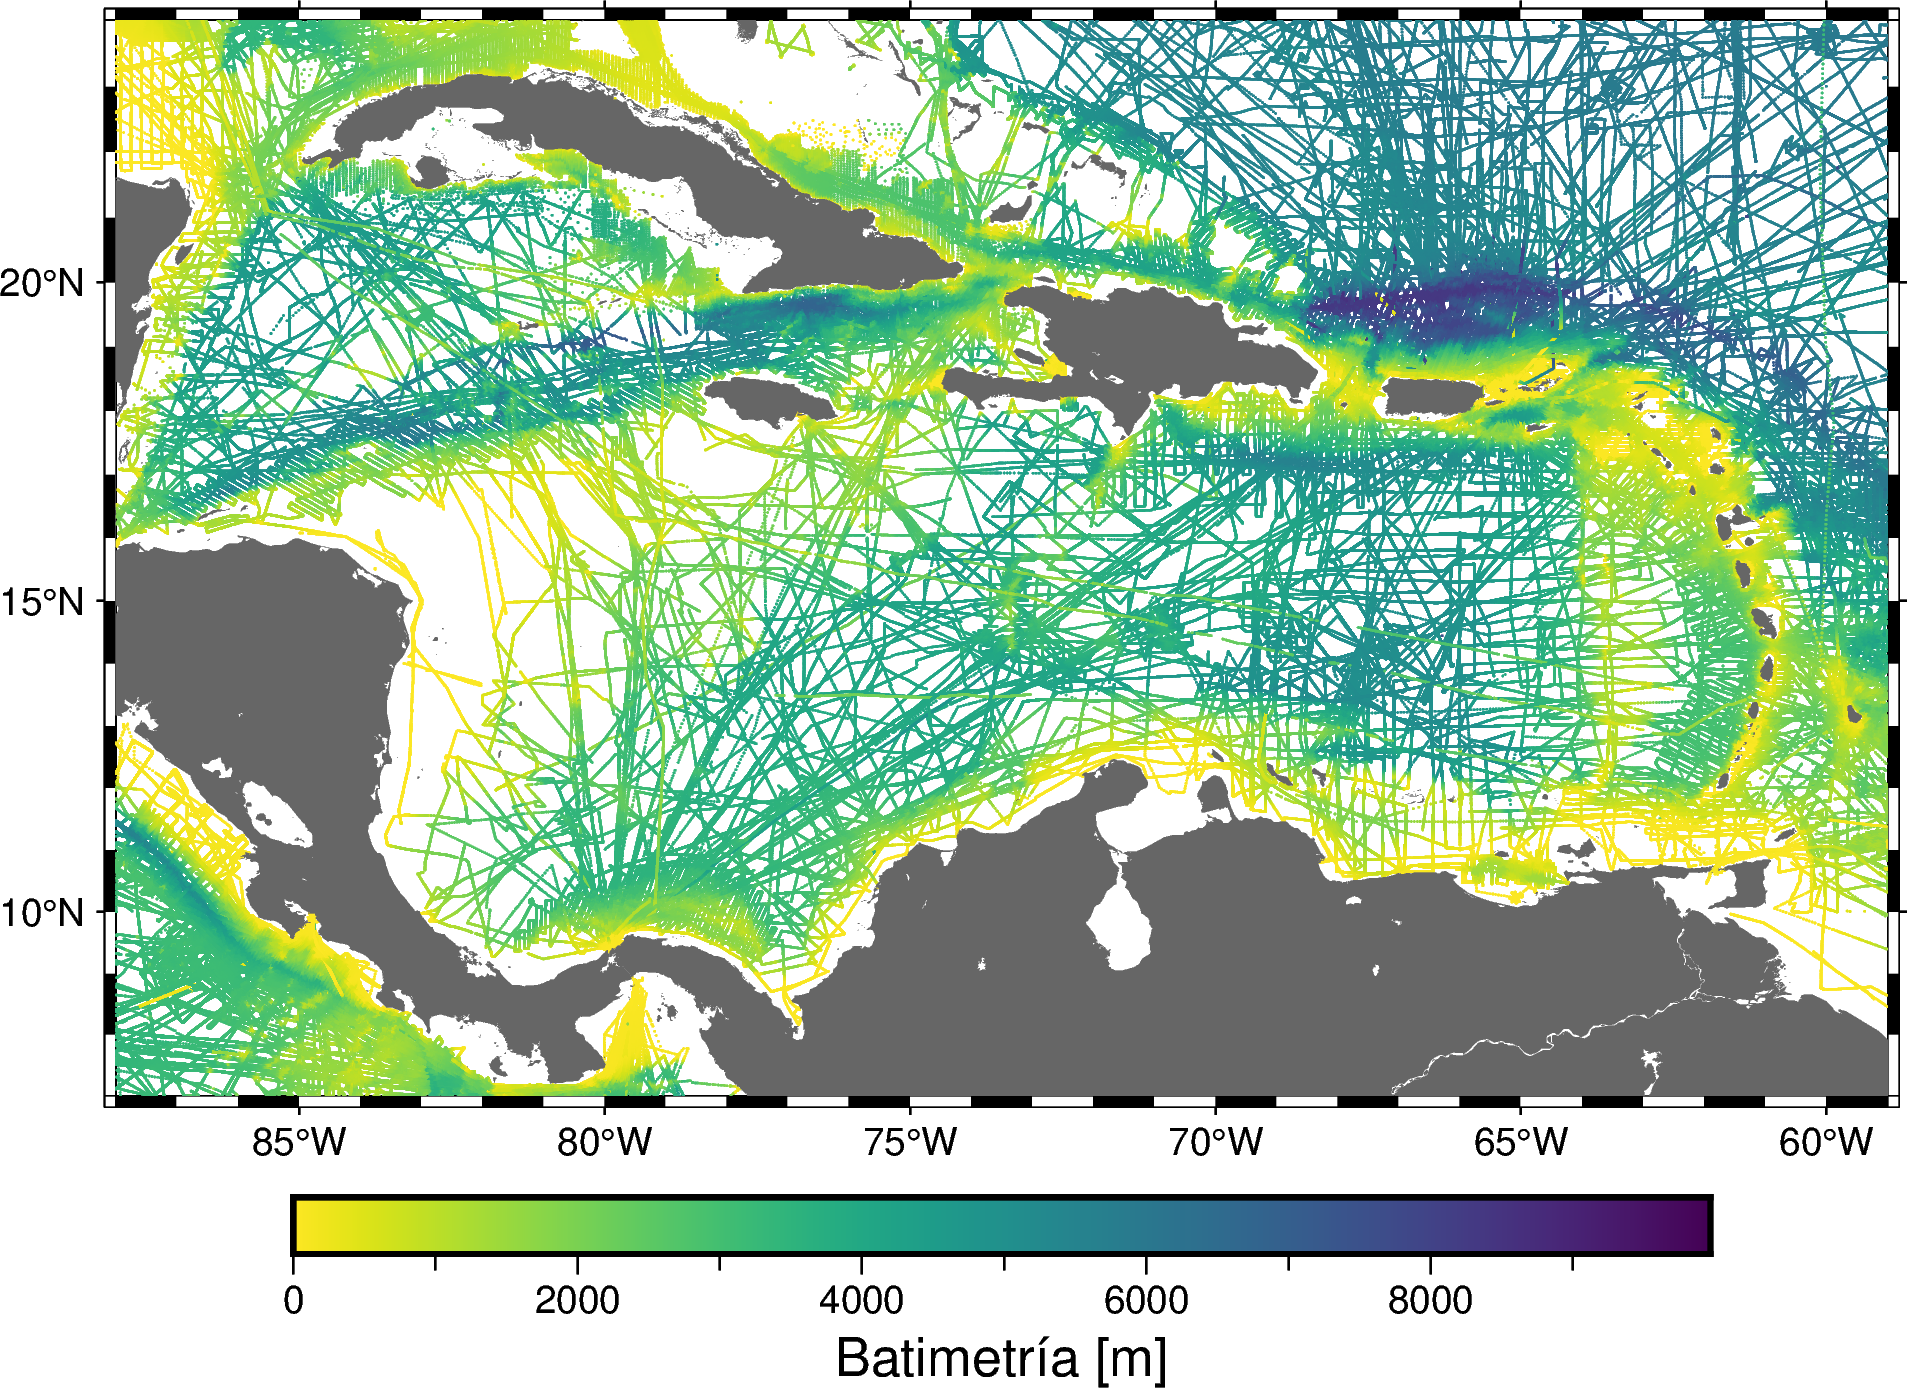

In [5]:
plot_geographic_scatter(
    data.longitude, data.latitude, data.depth_m, title="Batimetría [m]"
)

## Recortar los datos a una subregion

In [21]:
region = (-72, -60, 17, 25)

In [7]:
inside = vd.inside((data.longitude, data.latitude), region)
inside

0          False
1          False
2          False
3          False
4          False
           ...  
1938090    False
1938091    False
1938092    False
1938093    False
1938094    False
Length: 1938095, dtype: bool

In [8]:
data = data[inside]
data

survey_id  latitude  longitude  depth_m
2501     19920022  20.77899  -69.11683     4144
2502     19920022  20.79198  -69.13849     4083
2503     19920022  20.80388  -69.16176     4042
2504     19920022  20.81675  -69.18429     3971
2505     19920022  20.82881  -69.20634     3884
...           ...       ...        ...      ...
1913475    JR344T  17.00817  -69.72058     4736
1913476    JR344T  17.00624  -69.72319     4732
1913477    JR344T  17.00428  -69.72577     4723
1913478    JR344T  17.00230  -69.72835     4711
1913479    JR344T  17.00033  -69.73096     4701

[554000 rows x 4 columns]

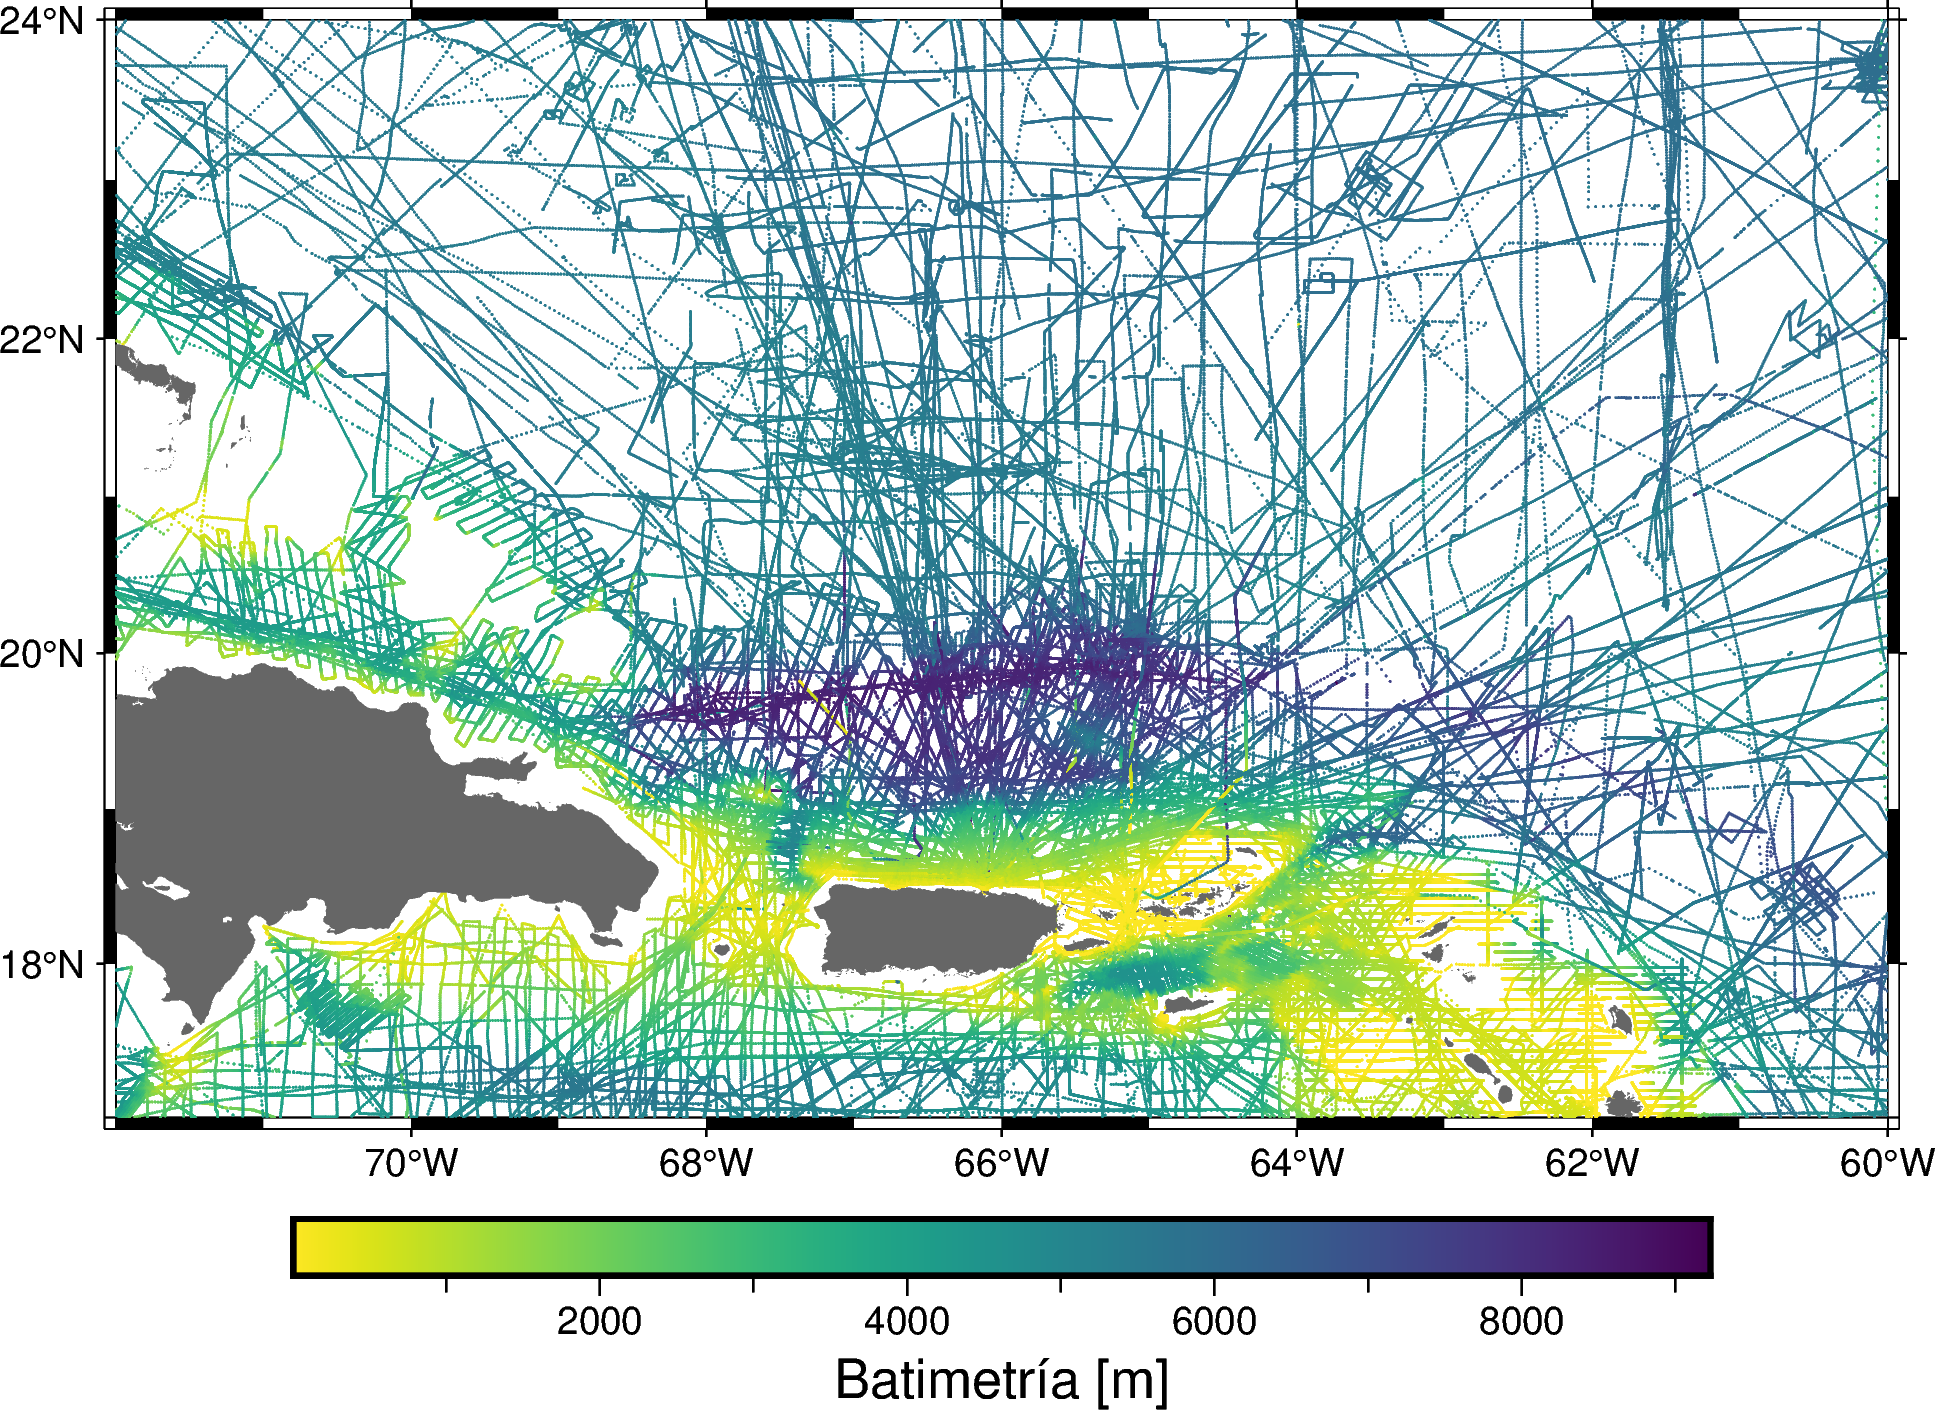

In [9]:
plot_geographic_scatter(
    data.longitude, data.latitude, data.depth_m, title="Batimetría [m]"
)

## Resampleo de datos (decimation)

In [8]:
spacing = 4 / 60
reducer = vd.BlockReduce(reduction=np.median, spacing=spacing)

In [11]:
spacing = 4 / 60
reducer = vd.BlockReduce(reduction=np.median, spacing=spacing)

In [12]:
(longitude, latitude), bathymetry = reducer.filter(
    coordinates=(data.longitude, data.latitude),
    data=data.depth_m,
)

In [13]:
reduced_data = pd.DataFrame(
    {"longitude": longitude, "latitude": latitude, "depth_m": bathymetry}
)
reduced_data

longitude   latitude  depth_m
0     -71.966335  17.035745   3964.5
1     -71.905860  17.038810   2824.0
2     -71.857740  17.038245   2481.0
3     -71.786660  17.026200   2557.5
4     -71.670000  17.035100   2549.0
...          ...        ...      ...
13759 -60.635800  23.943550   5907.0
13760 -60.588800  23.946000   5911.0
13761 -60.506100  23.939000   5827.0
13762 -60.463150  23.968350   5905.0
13763 -60.029150  23.967250   5815.0

[13764 rows x 3 columns]

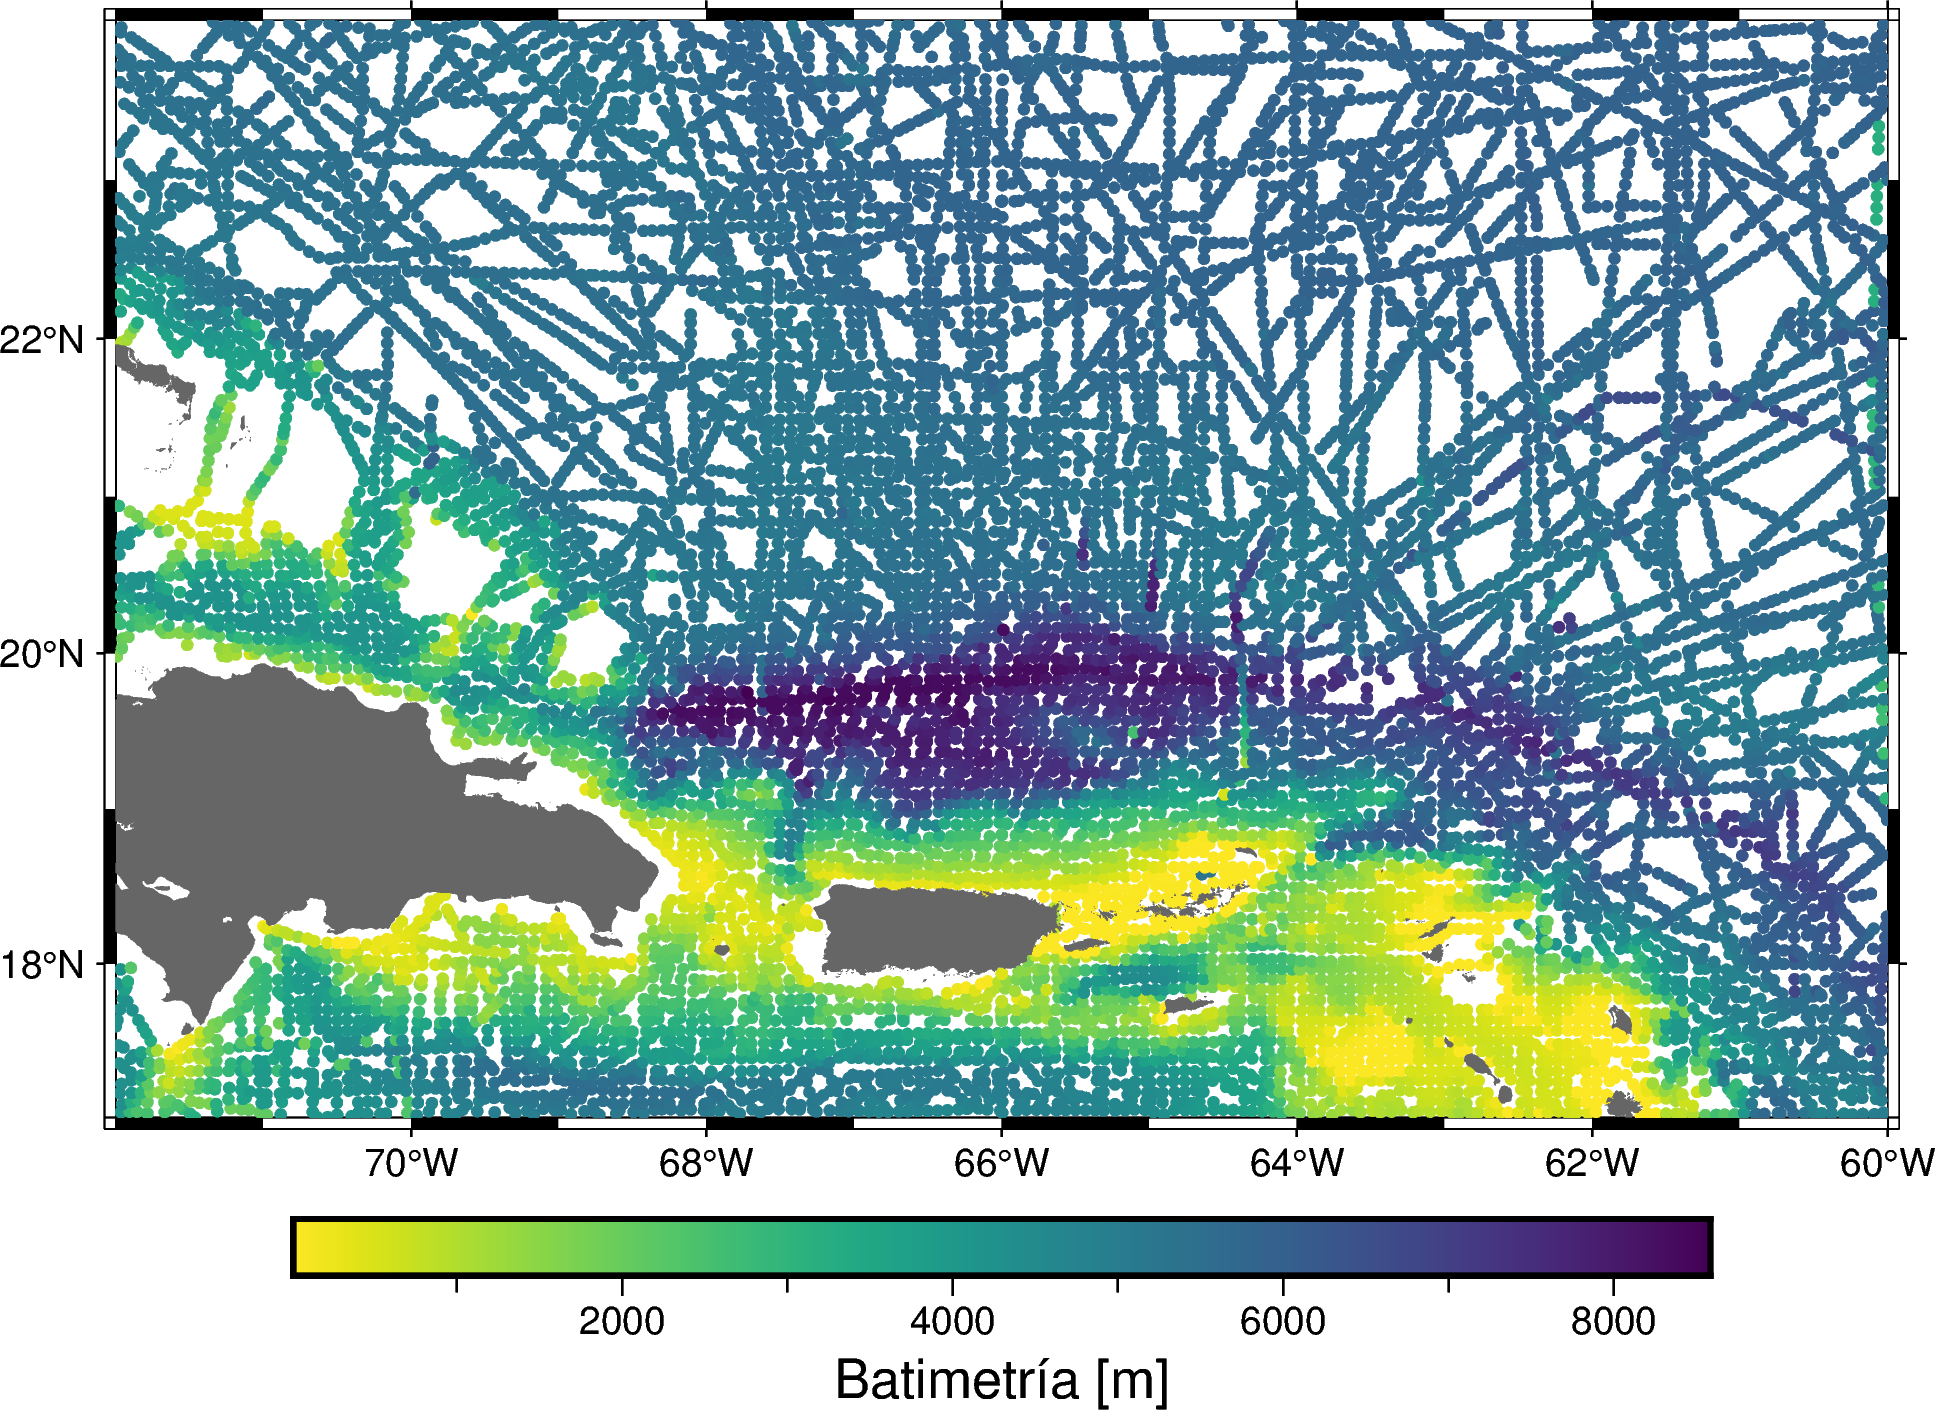

In [14]:
plot_geographic_scatter(
    reduced_data.longitude, reduced_data.latitude, reduced_data.depth_m, title="Batimetría [m]", style="c0.1c"
)

## Grillado

### Projectar los datos a coordenadas planas (cartesianas)

In [16]:
projection = pyproj.Proj(proj="merc", lat_ts=reduced_data.latitude.mean())
projection

<Other Coordinate Operation Transformer: merc>
Description: PROJ-based coordinate operation
Area of Use:
- undefined

In [17]:
easting, northing = projection(reduced_data.longitude.values, reduced_data.latitude.values)

In [18]:
reduced_data["easting"] = easting
reduced_data["northing"] = northing
reduced_data

longitude   latitude  depth_m       easting      northing
0     -71.966335  17.035745   3964.5 -7.513305e+06  1.793602e+06
1     -71.905860  17.038810   2824.0 -7.506991e+06  1.793935e+06
2     -71.857740  17.038245   2481.0 -7.501968e+06  1.793874e+06
3     -71.786660  17.026200   2557.5 -7.494547e+06  1.792567e+06
4     -71.670000  17.035100   2549.0 -7.482368e+06  1.793532e+06
...          ...        ...      ...           ...           ...
13759 -60.635800  23.943550   5907.0 -6.330394e+06  2.559559e+06
13760 -60.588800  23.946000   5911.0 -6.325487e+06  2.559838e+06
13761 -60.506100  23.939000   5827.0 -6.316853e+06  2.559042e+06
13762 -60.463150  23.968350   5905.0 -6.312369e+06  2.562377e+06
13763 -60.029150  23.967250   5815.0 -6.267060e+06  2.562252e+06

[13764 rows x 5 columns]

### Grillar los datos

In [19]:
spline = vd.Spline(damping=1e-7).fit(
    (reduced_data.easting, reduced_data.northing),
    reduced_data.depth_m,
)
spline

/home/santi/.mambaforge/envs/2023-fatiando-igeba/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.39096e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Spline(damping=1e-07)

In [22]:
grid = spline.grid(
    region=region,
    spacing=spacing,
    projection=projection,
    data_names="bathymetry",
    dims=("latitude", "longitude"),
)
grid

/home/santi/.mambaforge/envs/2023-fatiando-igeba/lib/python3.9/site-packages/verde/base/base_classes.py:463: FutureWarning: The 'spacing', 'shape' and 'region' arguments will be removed in Verde v2.0.0. Please use the 'verde.grid_coordinates' function to define grid coordinates and pass them as the 'coordinates' argument.
  warnings.warn(


<xarray.Dataset>
Dimensions:     (latitude: 121, longitude: 181)
Coordinates:
  * longitude   (longitude) float64 -72.0 -71.93 -71.87 ... -60.13 -60.07 -60.0
  * latitude    (latitude) float64 17.0 17.07 17.13 17.2 ... 24.87 24.93 25.0
Data variables:
    bathymetry  (latitude, longitude) float64 3.964e+03 3.512e+03 ... 5.847e+03
Attributes:
    metadata:  Generated by Spline(damping=1e-07)

Elimino valores negativos de batimetria (artefactos de la interpolacion)

In [23]:
grid["bathymetry"] = grid.bathymetry.where(grid.bathymetry >= 0, np.nan)
grid

<xarray.Dataset>
Dimensions:     (latitude: 121, longitude: 181)
Coordinates:
  * longitude   (longitude) float64 -72.0 -71.93 -71.87 ... -60.13 -60.07 -60.0
  * latitude    (latitude) float64 17.0 17.07 17.13 17.2 ... 24.87 24.93 25.0
Data variables:
    bathymetry  (latitude, longitude) float64 3.964e+03 3.512e+03 ... 5.847e+03
Attributes:
    metadata:  Generated by Spline(damping=1e-07)

Grafico la grilla

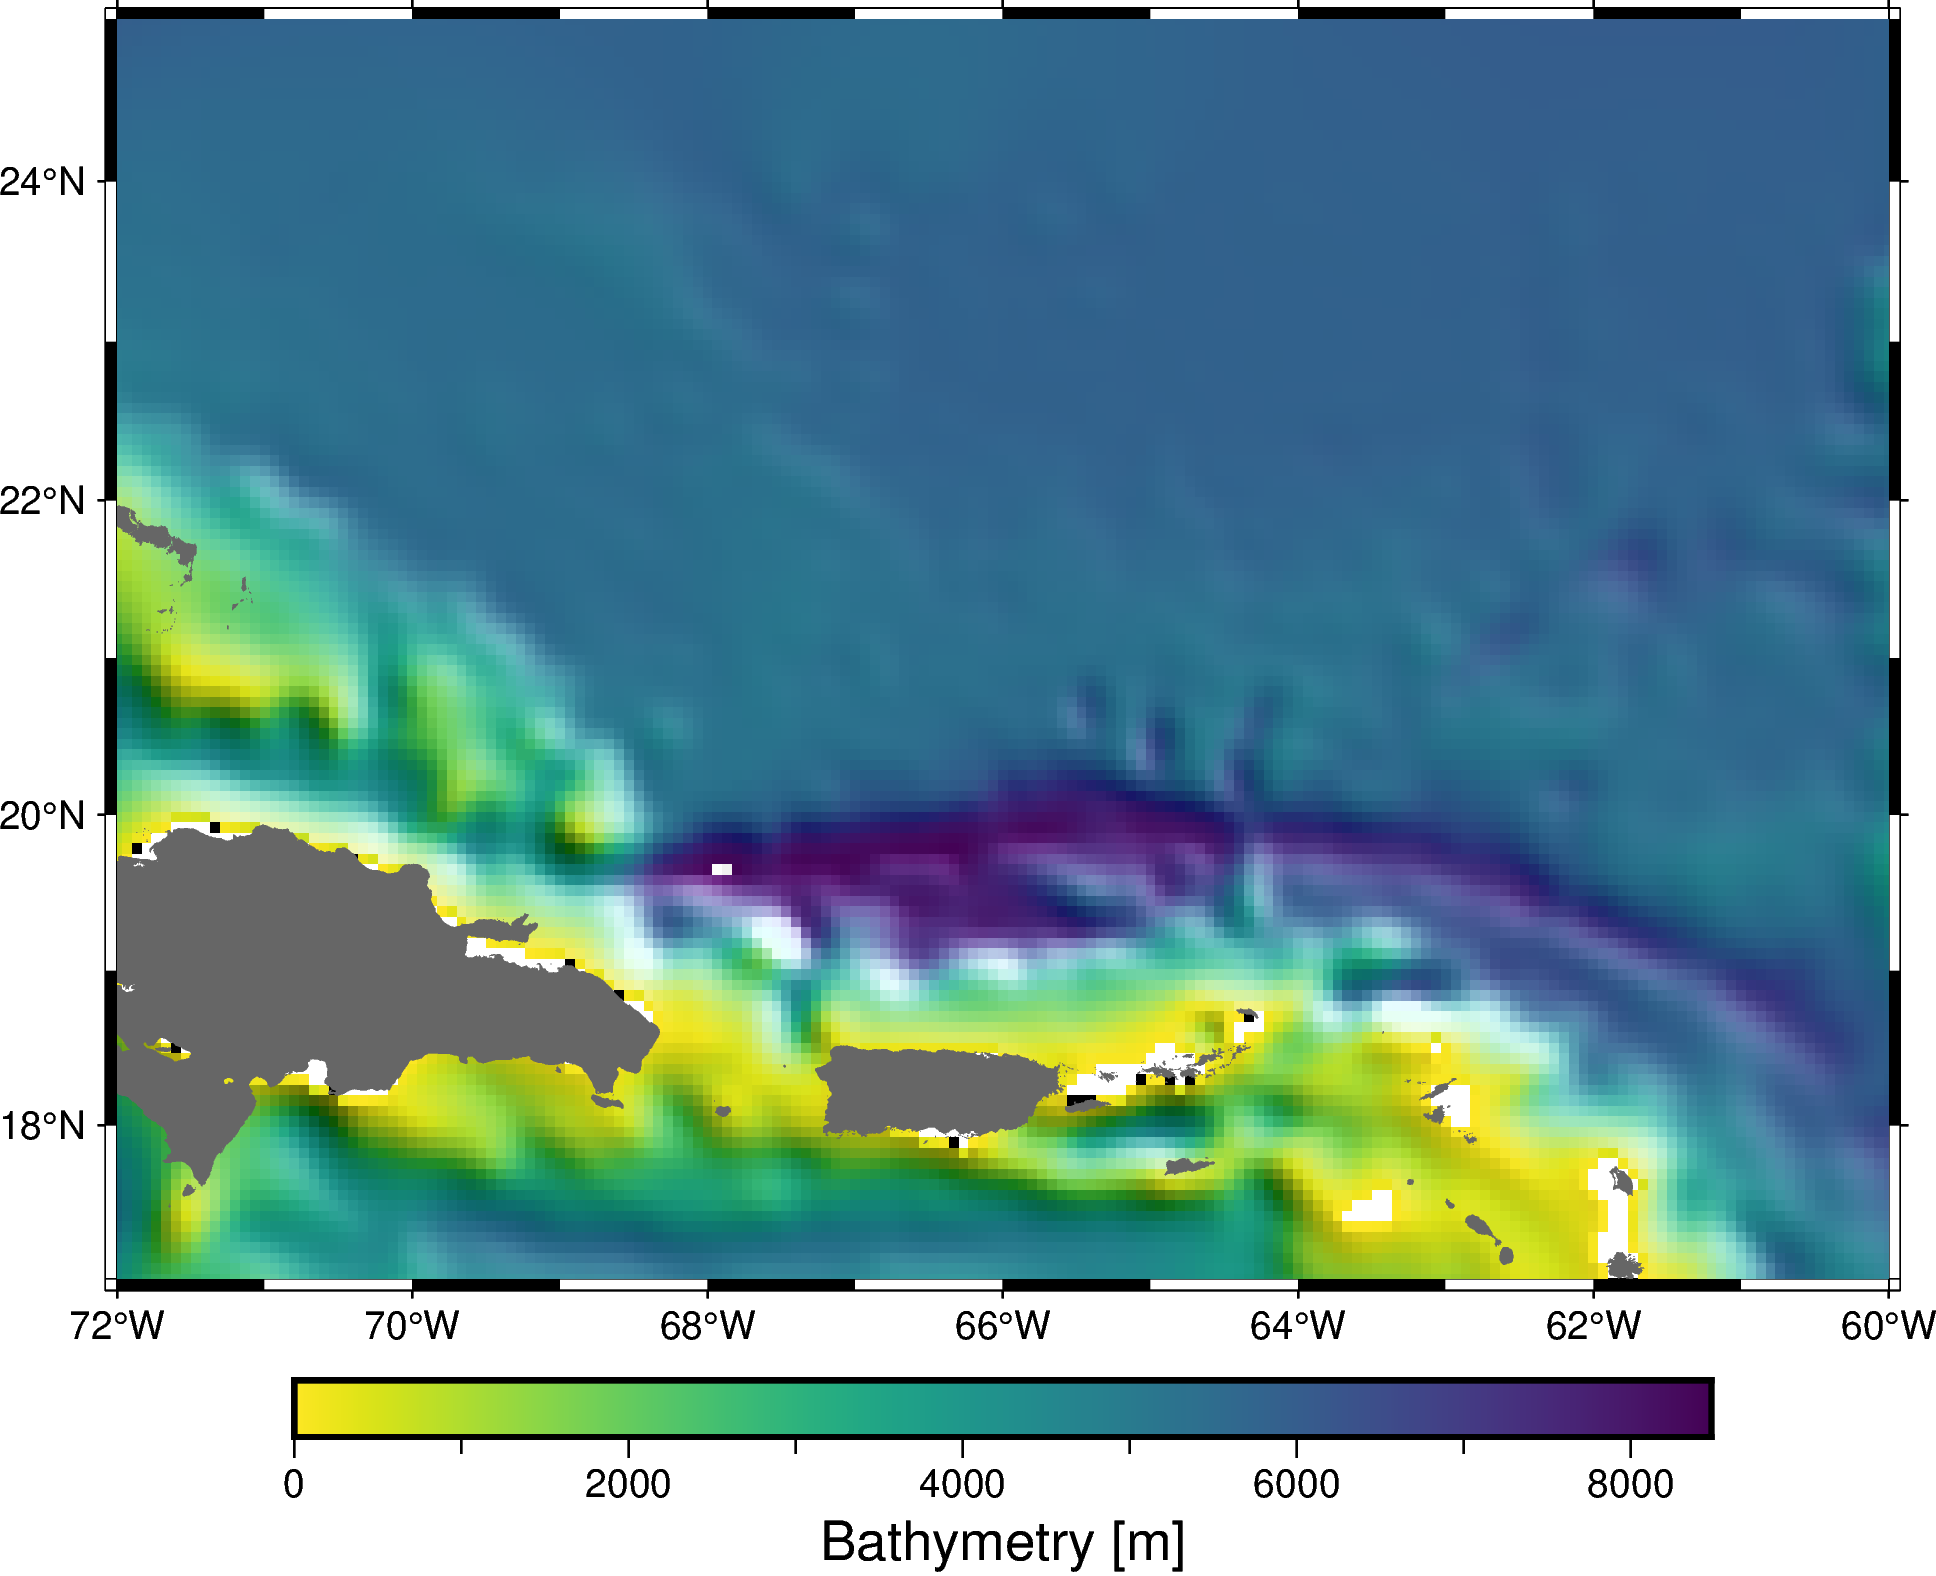

In [24]:
fig = pygmt.Figure()
gmt_projection = "M15c"

fig.basemap(
    region=[
        grid.longitude.values.min(),
        grid.longitude.values.max(),
        grid.latitude.values.min(),
        grid.latitude.values.max(),
    ],
    projection=gmt_projection,
    frame=True,
)

vmax = np.nanmax(grid.bathymetry.values)
pygmt.makecpt(cmap="viridis", series=[0, vmax], no_bg=True, reverse=True)
shade = pygmt.grdgradient(grid=-grid.bathymetry, azimuth=45, normalize=1.5) # use negative bathymetry for shading
fig.grdimage(
    grid=grid.bathymetry,
    cmap=True,
    shading=shade,
    projection=gmt_projection,
    nan_transparent=True,
)


frame = 'af+l"Bathymetry [m]"'
fig.colorbar(frame=frame)
fig.coast(land="#666666", resolution="h")
fig.show()

/tmp/ipykernel_34127/1668317892.py:26: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(


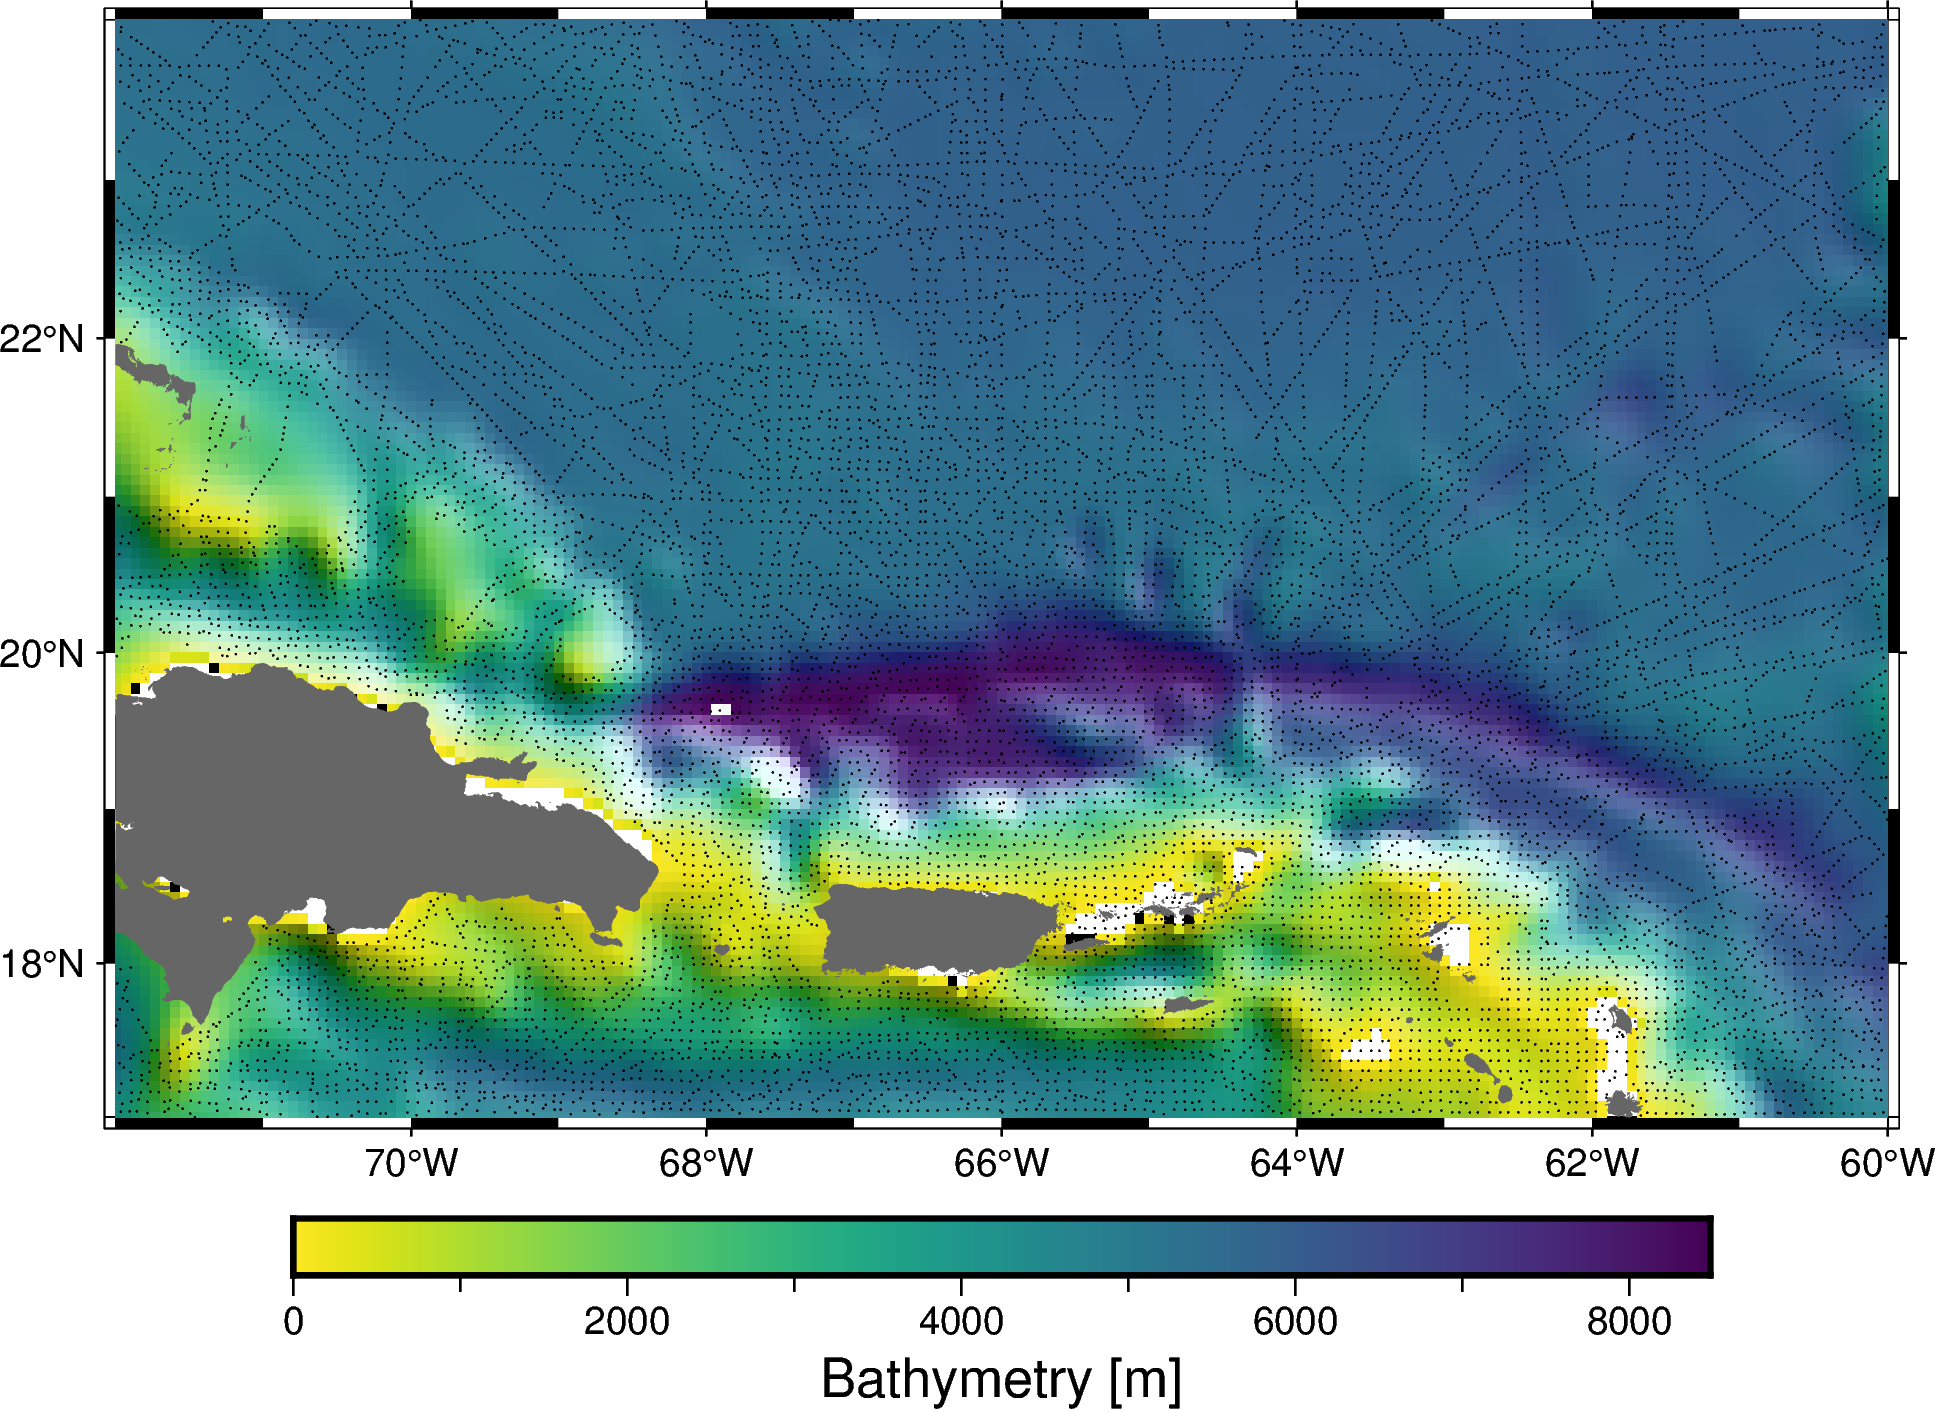

In [28]:
fig = pygmt.Figure()
gmt_projection = "M15c"

fig.basemap(
    region=[
        grid.longitude.values.min(),
        grid.longitude.values.max(),
        grid.latitude.values.min(),
        grid.latitude.values.max(),
    ],
    projection=gmt_projection,
    frame=True,
)

vmax = np.nanmax(grid.bathymetry.values)
pygmt.makecpt(cmap="viridis", series=[0, vmax], no_bg=True, reverse=True)
shade = pygmt.grdgradient(grid=-grid.bathymetry, azimuth=45, normalize=1.5) # use negative bathymetry for shading
fig.grdimage(
    grid=grid.bathymetry,
    cmap=True,
    shading=shade,
    projection=gmt_projection,
    nan_transparent=True,
)

fig.plot(
    x=reduced_data.longitude,
    y=reduced_data.latitude,
    style="c0.5p",
    color="black",
    projection=gmt_projection,
    frame=False,
)

frame = 'af+l"Bathymetry [m]"'
fig.colorbar(frame=frame)
fig.coast(land="#666666", resolution="h")
fig.show()